In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet import preprocess_input

In [2]:
Train_data = 'D:\\Omkar Project\\chest_xray\\train\\'
Test_data = 'D:\\Omkar Project\\chest_xray\\test\\'

train_data_df = pd.DataFrame(columns=['Image_path','Label'])
test_data_df = pd.DataFrame(columns=['Image_path','Label'])

In [3]:
def load_dataframe(DF,path):
    labels_files = os.listdir(path)
    image_paths = []
    labels = []
    for file in labels_files:
        path_file = path + file +'\\'
        list_files = os.listdir(path_file)
        for image_path in list_files:
            image_paths.append(path_file + image_path)
            labels.append(file)
    DF['Image_path'] = image_paths
    DF['Label'] = labels
    return(DF)

In [4]:
train_data_df = load_dataframe(train_data_df,Train_data)
test_data_df = load_dataframe(test_data_df,Test_data)

train_data_df = shuffle(train_data_df)
test_data_df = shuffle(test_data_df)

encoder = LabelEncoder()
train_data_df['Label'] = encoder.fit_transform(train_data_df['Label'])
test_data_df['Label'] = encoder.fit_transform(test_data_df['Label'])

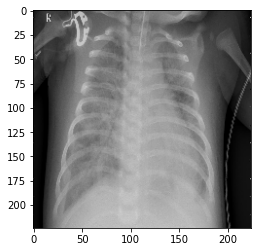

(224, 224, 3)

In [5]:
import cv2
def load_image(path):
    img = cv2.imread(path,1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    img = cv2.resize(img,(224,224))
    return img

img = load_image(train_data_df['Image_path'][0])
fig,ax = plt.subplots(1)
ax.imshow(img)
plt.show()

img.shape

In [6]:
x_train = []
for image_path in train_data_df['Image_path'] :
    img = load_image(image_path)
    img = preprocess_input(np.array(img, dtype=np.float32))
    x_train.append(img)
x_train = np.array(x_train)

In [7]:
x_test = []
for image_path in test_data_df['Image_path'] :
    img = load_image(image_path)
    img = preprocess_input(np.array(img, dtype=np.float32))
    x_test.append(img)
x_test = np.array(x_test)

In [8]:
y_train = train_data_df['Label'].to_list()
y_test = test_data_df['Label'].to_list()

In [9]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train,num_classes=3)
y_train = y_train.reshape(y_train.shape[0],1,1,y_train.shape[1])
y_test = to_categorical(y_test,num_classes=3)
y_test = y_test.reshape(y_test.shape[0],1,1,y_test.shape[1])

In [79]:
from tensorflow.keras.applications.mobilenet import MobileNet 
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D,Conv2DTranspose,Dropout,Dense,MaxPool2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable    

    x =  model.output
    x = Conv2D(512, kernel_size=3,padding ='same',activation="relu")(x)
    x = MaxPool2D()(x)
    x = Conv2D(256, kernel_size=3,padding ='same',activation="relu")(x)
    x = MaxPool2D()(x)
    x = Dense(512,activation = 'relu')(x)
    x = Dense(3,activation = 'softmax')(x)
    return(Model(inputs = model.input,outputs = x))

In [80]:
model = create_model(False)
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0  

In [81]:
import tensorflow
Optimizer = tensorflow.keras.optimizers.Adam(lr = 1e-6,beta_1 = 0.9,decay = 1e-5)

model.compile(optimizer= Optimizer,loss= 'categorical_crossentropy',metrics= 'accuracy')

In [82]:
EarlyStopping = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,min_delta = 0.01)
# Model Checkpoint
ModelCheckpoint = tensorflow.keras.callbacks.ModelCheckpoint("pneu_2-{val_loss:.3f}.h5",monitor='val_loss',save_best_only= True,save_weights_only=True)

In [83]:
model_history = model.fit(x_train,y_train,epochs = 10,batch_size = 1,validation_data = (x_test,y_test),callbacks=[ModelCheckpoint,EarlyStopping])

Epoch 1/10
5216/5216 [==============================] - 410s 78ms/step - loss: 0.7862 - accuracy: 0.6435 - val_loss: 0.6439 - val_accuracy: 0.7372
Epoch 2/10
5216/5216 [==============================] - 388s 74ms/step - loss: 0.4448 - accuracy: 0.8169 - val_loss: 0.6181 - val_accuracy: 0.7660
Epoch 3/10
5216/5216 [==============================] - 395s 76ms/step - loss: 0.3594 - accuracy: 0.8592 - val_loss: 0.6464 - val_accuracy: 0.7580
Epoch 4/10
5216/5216 [==============================] - 379s 73ms/step - loss: 0.2975 - accuracy: 0.8928 - val_loss: 0.6618 - val_accuracy: 0.7612


In [85]:
def plotModelAccuracy(history, modelname):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title(modelname+' model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title(modelname+' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

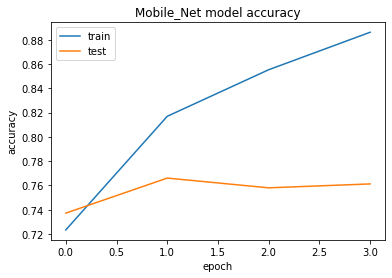

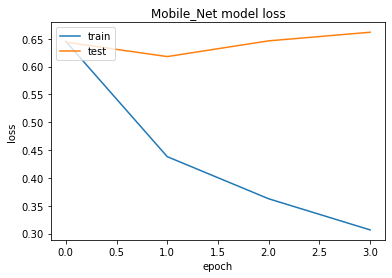

In [86]:
plotModelAccuracy(model_history, 'Mobile_Net')

In [63]:
model.save('C:\\Users\\Kalpesh\\Great lakes\\Object Detection')

INFO:tensorflow:Assets written to: C:\Users\Kalpesh\Great lakes\Object Detection\assets


INFO:tensorflow:Assets written to: C:\Users\Kalpesh\Great lakes\Object Detection\assets


In [75]:
_model = create_model(True)
_model.load_weights('pneu_2-0.628.h5')

In [65]:
np.array(x_train[20,:,:,:]).reshape(1,224,224,3)

array([[[[-0.827451  , -0.827451  , -0.827451  ],
         [-0.8352941 , -0.8352941 , -0.8352941 ],
         [-0.84313726, -0.84313726, -0.84313726],
         ...,
         [-0.8039216 , -0.8039216 , -0.8039216 ],
         [-0.81960785, -0.81960785, -0.81960785],
         [-0.81960785, -0.81960785, -0.81960785]],

        [[-0.8352941 , -0.8352941 , -0.8352941 ],
         [-0.84313726, -0.84313726, -0.84313726],
         [-0.8509804 , -0.8509804 , -0.8509804 ],
         ...,
         [-0.8117647 , -0.8117647 , -0.8117647 ],
         [-0.81960785, -0.81960785, -0.81960785],
         [-0.81960785, -0.81960785, -0.81960785]],

        [[-0.84313726, -0.84313726, -0.84313726],
         [-0.8509804 , -0.8509804 , -0.8509804 ],
         [-0.85882354, -0.85882354, -0.85882354],
         ...,
         [-0.81960785, -0.81960785, -0.81960785],
         [-0.81960785, -0.81960785, -0.81960785],
         [-0.81960785, -0.81960785, -0.81960785]],

        ...,

        [[-0.7647059 , -0.7647059 , -0

In [76]:
pred = _model.predict(np.array(x_train[120,:,:,:]).reshape(1,224,224,3))

In [ ]:
model_history = self._model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs, callbacks=[checkpoint,reduceLoss], validation_data=(X_Val,y_Val))

In [ ]:
  def plotModelAccuracy(self, history, modelname):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title(modelname+' model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title(modelname+' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

In [67]:
encoder.classes_[np.argmax(pred)]

'bacteria'

In [68]:
encoder.classes_[np.argmax(y_train[120][0][0])]

'bacteria'

In [69]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet import preprocess_input
from myhdl import *

def predict(image):
    
    _model = create_model(True)
    _model.load_weights('pneu_2-0.628.h5')
    image = cv2.resize(image, (224,224))
    pred = _model.predict(np.array(image).reshape(1,224,224,3))
    lab = encoder.classes_[np.argmax(pred)]
    return(lab)



In [70]:
image = cv2.imread('D:\\Omkar Project\\chest_xray\\train\\normal\\IM-0191-0001.jpeg', 1)
predict(image)

'normal'

In [74]:
converter = tf.lite.TFLiteConverter.from_keras_model(_model) # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
with open('mobnet_model1.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Kalpesh\AppData\Local\Temp\tmpw1y4iklu\assets


INFO:tensorflow:Assets written to: C:\Users\Kalpesh\AppData\Local\Temp\tmpw1y4iklu\assets
